In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
tf.random.set_seed(69)
random.seed(69)
np.random.seed(69)
os.environ["PYTHONHASHSEED"] = str(69)

In [3]:
d = pd.read_csv('./data/daily.csv')
d = d[4507:]
d.to_csv('./data/dailyChopped.csv')
df = pd.read_csv('./data/dailyChopped.csv')
df.head()

,Unnamed: 0,Day,Price
0,4507,20150105,3.22
1,4508,20150106,2.98
2,4509,20150107,3.08
3,4510,20150108,2.92
4,4511,20150109,2.96


In [4]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j]])
        xRes.append(res)
        yRes.append(df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [5]:
SPLIT = 0.85
xVal, yVal = singleStepSampler(df, 20)
xTrain = xVal[:int(SPLIT*len(xVal))]
yTrain = yVal[:int(SPLIT*len(yVal))]
xTest = xVal[int(SPLIT*len(xVal)):]
yTest = yVal[int(SPLIT*len(yVal)):]
(xTrain.shape, xTest.shape)

(TensorShape([1575, 20, 1]), TensorShape([278, 20, 1]))

In [6]:
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(20, 1)))
model.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [35]:
model.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
50/50 [==============================] - 2s 9ms/step - loss: 0.5140 - mse: 0.9105 - mae: 0.5140 - smape: 0.1953
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2499 - mse: 0.4652 - mae: 0.2499 - smape: 0.0867
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2542 - mse: 0.4637 - mae: 0.2542 - smape: 0.0883
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2188 - mse: 0.4254 - mae: 0.2188 - smape: 0.0751
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2090 - mse: 0.3993 - mae: 0.2090 - smape: 0.0718
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1880 - mse: 0.3821 - mae: 0.1880 - smape: 0.0639
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1646 - mse: 0.3423 - mae: 0.1646 - smape: 0.0556
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1760 - mse: 0.3425 - mae: 0.1760 - smape: 0.0601
Epoch 9/50
50/50

In [36]:
model.evaluate(xTest, yTest)

9/9 [==============================] - 0s 4ms/step - loss: 0.2018 - mse: 0.1004 - mae: 0.2018 - smape: 0.0418


[0.2017834186553955,
 0.10035832226276398,
 0.2017834186553955,
 0.04176916554570198]

In [28]:
data = []
for item in xTest:
    data.append(model.predict(np.array([item])))

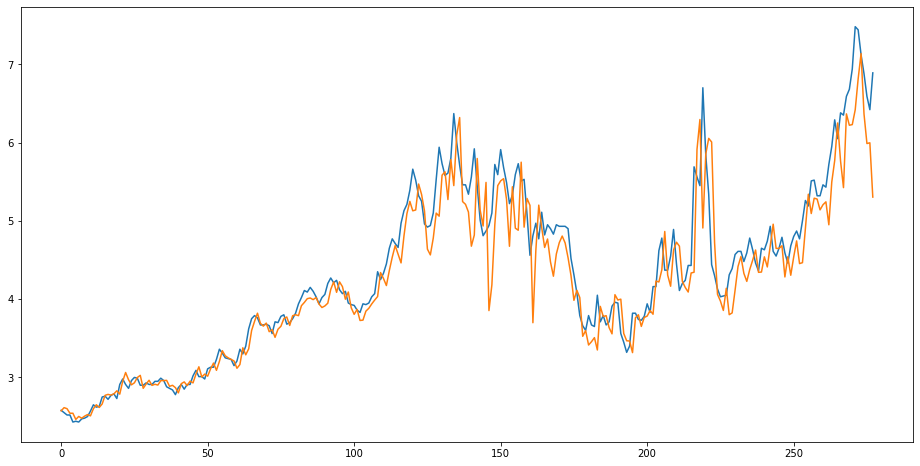

In [29]:
dafr = pd.DataFrame(data={'actual': yTest, 'prediction': [item[0][0] for item in data]})
plt.figure(figsize=(16, 8))
plt.plot(dafr)
plt.show()

In [ ]:
model.save('./models/singleStepDailyHybrid.h5')